# Using ResNet for image classification.

There are many ways of tackling an image classification problem using ML, even for simple problems, current ML landscape presents us many options from simple linear Neural Networks to bigger more complex architectures. On this project, I used the Intel image classification dataset hosted on **Kaggle** *(https://www.kaggle.com/puneet6060/intel-image-classification)*, this dataset was initially created by Intel for an image classification challenge. The dataset contains about 25k images, 14k for training, 3k for testing(validation) and 7k used in the original challenge for the participants to make their predictions.

Using this Dataset, I’m going to present results of Residual neural networks (ResNet) used for Image classification to test the accuracy they present for these images, first creating it piece by piece and then importing and adapting a pre trained ResNet.

**First, we get some important libraries and import the data.**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #For ploting
import torch    #Pytorch
import os

In [2]:
# Look into the data directory
data_dir = '../input/intel-image-classification'
#print(os.listdir(data_dir))

#Training data directory
train_dir = (data_dir + '/seg_train/seg_train')
print('Classes:')
print(os.listdir(train_dir))

#Test data directory
test_dir = (data_dir + '/seg_test/seg_test')
#print(os.listdir(test_dir))

#pred_dir = (data_dir + '/seg_pred/seg_pred')

Classes:
['glacier', 'sea', 'forest', 'street', 'mountain', 'buildings']


# Creating the datasets 

In [3]:
import torchvision.transforms as tt #To apply transformations to the dataset, augmenting it and transforming it to a tensor.
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder #Load dataset

Now, we define the transformations to be applied to the images. This way we augment the dataset, allowing for better generalization and helping prevent overfitting.

In [4]:
#Transformations aplied to test DS.
train_tf = tt.Compose([         
    tt.ColorJitter(brightness=0.2),
    tt.Resize(size=(150,150)),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(5),
    tt.ToTensor(),            
])

#Transformations aplied to test DS.
test_tf= tt.Compose([   
    tt.Resize(size=(150,150)),
    tt.ToTensor(),
])

Getting the images.

In [5]:
train_ds = ImageFolder(train_dir,train_tf)
test_ds = ImageFolder(test_dir,test_tf)

len(train_ds), len(test_ds)

(14034, 3000)

In [6]:
img,label=train_ds[0]
img.shape

torch.Size([3, 150, 150])

Showing some information about the dataset.

In [7]:
def ds_info(dataset):
    dataset_size=len(dataset)
    classes = dataset.classes
    num_classes = len(classes)
    
    #Initialize list
    count = []     
    for x in range(num_classes):
        count.append(0)
        
    #Count every label
    for x in range(dataset_size):
        count[dataset[x][1]]+=1
        
    print('Size of the dataset:' + str(dataset_size))
    print('Number of classes:' + str(num_classes))    
    print('Samples for every class:')
    
    #Print the count
    for x in range(num_classes):
        print(classes[x] + " : " + str(count[x]))
    

In [8]:
print('Training dataset information:')
ds_info(train_ds)

Training dataset information:
Size of the dataset:14034
Number of classes:6
Samples for every class:
buildings : 2191
forest : 2271
glacier : 2404
mountain : 2512
sea : 2274
street : 2382


In [9]:
print('Test dataset information:')
ds_info(test_ds)

Test dataset information:
Size of the dataset:3000
Number of classes:6
Samples for every class:
buildings : 437
forest : 474
glacier : 553
mountain : 525
sea : 510
street : 501


Next let's separate the data in batches, so we can load them on the GPU later and pass them through the networks.

In [10]:
batch_size = 254

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=True,
    pin_memory=True
)

test_dl = DataLoader(
    test_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=False,
    pin_memory=True
)

It's a good idea to visualize some of the samples to see if transformations make sense and aren’t too disruptive of the original data.

In [11]:
from torchvision.utils import make_grid

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

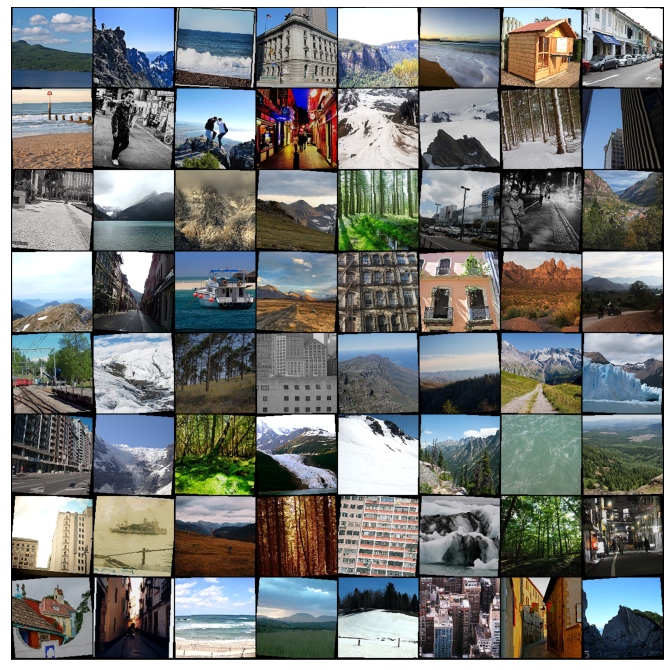

In [13]:
%matplotlib inline
show_batch(train_dl)

Finally, we create a helper class and functions that allow us to pass the data and networks to the GPU.

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device() #Getting the device
device

train_dl = DeviceDataLoader(train_dl, device) #Transfering train data to GPU
test_dl = DeviceDataLoader(test_dl, device)   #Transfering test data to GPU

# Creating the Networks

For the first run we're going to create the base network class, this way we can define steps that are general for training and data handling that’s independent (to a certain degree) of the specific network architecture.

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

We create an accuracy function that counts the amount of correct predictions and divides it with the size of the batch. It gives us a metric of how good the network it's getting.

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We create a base class with some helper functions that are going to allow us to test different architectures easier and make comparison clearer.

* **training_step**: used to pass training batch trough the network and calculate the loss.
* **validation step**: similar to training but used for test data, the only difference is that this one also calculates the accuracy and returns both results.
* **validation_epoch_end**: once a whole validation data passes through, this function is going to get the mean loss and accuracy.
* **epoch_end**: this one help us keep track of performance during training showing loss and accuracy on every epoch.

In [18]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            (epoch+1), result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

**ResNet9**

Now we define the specific network architecture.
First, we build a small ResNet from each of its layers, which are a series of convolutional blocks that encapsulate a convolutional layer, normalization of the data, a nonlinear activation function (RELU) and in some steps a max pooling layer.

On this specific implementation the architecture it's as follows:

1. **Convolutional Block (CL-Norm-ReLu),          output shape: 32x150x150**
1. **Convolutional Block (CL-Norm-ReLu-MaxPool4), output shape: 64x37x37**
1. **Residual Block (ConvB-ConvB),                output shape: 64x37x37**
1. **Convolutional Block (CL-Norm-ReLu-MaxPool4), output shape: 128x9x9**
1. **Convolutional Block (CL-Norm-ReLu-MaxPool4), output shape: 256x2x2**
1. **Residual Block (ConvB-ConvB),                output shape: 256x2x2**
1. **Final block (MaxPool2-Lineal Layer),         output shape: 6**

Now, because residual block is actually a couple of convolutional blocks, this means this network has 9 "blocks", so it is called ResNet9.


In [19]:
def conv_block(in_channels, out_channels, pool=False,p_size=2):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(p_size))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32)                             #32x150x150
        self.conv2 = conv_block(32, 64, pool=True,p_size=4)                  #64x37x37
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        
        self.conv3 = conv_block(64, 128, pool=True,p_size=4)                 #128x9x9
        self.conv4 = conv_block(128, 256, pool=True,p_size=4)                #256x2x2
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2),                     #256x1x1
                                        nn.Flatten(), 
                                        nn.Linear(256, num_classes))
        
    def forward(self, xb):
        
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        
        out = self.classifier(out)
        
        return out

Before testing it, let's define The bigger sister ResNet34.

**Resnet34**

This architecture it's basically a bigger version of the implemented ResNet, which allows for a deeper and potentially more powerful network. At the same time this architecture already exists on pythorch Libraries pre trained, which means it already knows how to classify images (even more complex than the test done on this project), so we're going to take advantage of that training and adapt it to this specific problem. The only requirement it's adapting its last layer, replacing it with a simple linear layer with the amount of outputs (classes) of our project and retraining it quickly allows us to adapt it.
To be able to train the last layer without touching the whole network, a freeze and unfreeze methods which allow just that.


In [20]:
class Resnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 6)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

Now we create some functions to automatize and simplify training independent of the network.

In [21]:
from tqdm.notebook import tqdm

* **evaluate**: run the validation step (defines and explained before) for each batch, this gets us the loss and accuracy for the test dataset.
* **get_lr**: get the current learning rate, the utility of this function will be clear in a moment.
* **fit_one_cycle**: the training function. Its parameters are:

        epochs: number of epochs to train for.
        Maximum learning rate: we're going to use a one cycle learning rate scheduler, which will update the learning rate for each epoch.
        Model: the network to be trained.
        Train Loader: Training dataset.
        Val Loader: Test dataset.
        Weight decay: a weight decay can be configured.
        Grad clip: if gradient clipping it's desired it can be set.
        opt_func: desired optimization function.


In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

And finally let's define some functions to help us visualize the results.

* **plot_scores**: plot the accuracy for each epoch.
* **plot_losses**: plot training and validation loss for each epoch.
* **predict image**: run an image through the network and get a prediction.


In [23]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [25]:
def show_sample(img, target):
    plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)
    
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    show_sample(img,test_ds.classes[preds[0].item()])

# ResNet9

In [26]:
model = to_device(ResNet9(3,6), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

Base performance:

In [27]:
history = [evaluate(model, test_dl)]
history

[{'val_loss': 1.7946200370788574, 'val_acc': 0.15583990514278412}]

Hyperparameters:

In [28]:
epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [29]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [1], last_lr: 0.00027, train_loss: 1.0134, val_loss: 0.7788, val_acc: 0.7050



Epoch [2], last_lr: 0.00076, train_loss: 0.5622, val_loss: 0.6948, val_acc: 0.7562



Epoch [3], last_lr: 0.00100, train_loss: 0.4649, val_loss: 1.0276, val_acc: 0.6433



Epoch [4], last_lr: 0.00095, train_loss: 0.3911, val_loss: 1.1015, val_acc: 0.6282



Epoch [5], last_lr: 0.00081, train_loss: 0.3383, val_loss: 0.5905, val_acc: 0.7938



Epoch [6], last_lr: 0.00061, train_loss: 0.2933, val_loss: 0.4791, val_acc: 0.8377



Epoch [7], last_lr: 0.00039, train_loss: 0.2523, val_loss: 0.4074, val_acc: 0.8668



Epoch [8], last_lr: 0.00019, train_loss: 0.2113, val_loss: 0.3160, val_acc: 0.8885



Epoch [9], last_lr: 0.00005, train_loss: 0.1822, val_loss: 0.2749, val_acc: 0.9082



Epoch [10], last_lr: 0.00000, train_loss: 0.1657, val_loss: 0.2777, val_acc: 0.9045
CPU times: user 36.2 s, sys: 23.5 s, total: 59.7 s
Wall time: 5min 54s


**Results:**

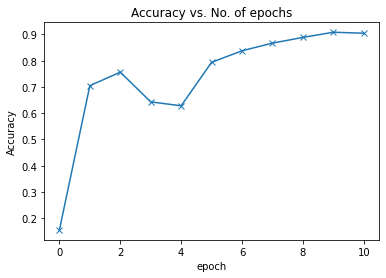

In [30]:
plot_scores(history)

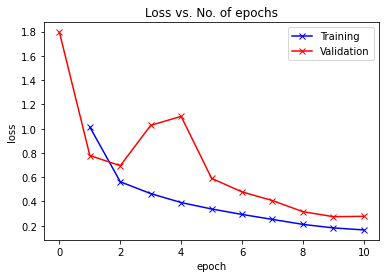

In [31]:
plot_losses(history)

Predicting some images:

Labels: mountain


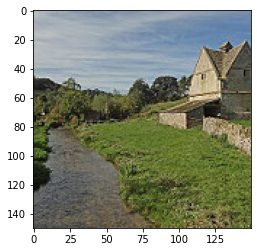

In [32]:
predict_image(test_ds[5][0],model)

Labels: forest


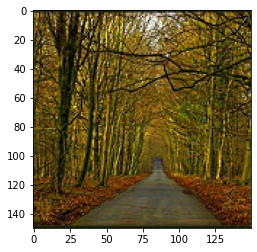

In [33]:
predict_image(test_ds[505][0],model)

Labels: glacier


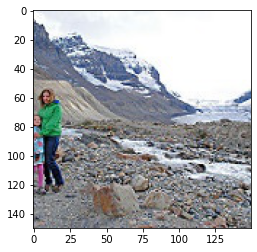

In [34]:
predict_image(test_ds[1005][0],model)

# ResNet34

In [35]:
model = to_device(Resnet34(), device)
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Resnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

Base results:

In [36]:
history = [evaluate(model, test_dl)]
history

[{'val_loss': 1.7998347282409668, 'val_acc': 0.2182523012161255}]

Hyperparameters:

In [37]:
epochs = 5
epochs2 = 5
max_lr2 = 0.00005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

**Training only the last layer:**

In [38]:
model.freeze()

In [39]:
%%time
history += fit_one_cycle(epochs2, max_lr2, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [1], last_lr: 0.00004, train_loss: 1.5856, val_loss: 1.3082, val_acc: 0.8584



Epoch [2], last_lr: 0.00005, train_loss: 1.1966, val_loss: 1.1382, val_acc: 0.9203



Epoch [3], last_lr: 0.00003, train_loss: 1.1213, val_loss: 1.1176, val_acc: 0.9261



Epoch [4], last_lr: 0.00001, train_loss: 1.1037, val_loss: 1.1113, val_acc: 0.9330



Epoch [5], last_lr: 0.00000, train_loss: 1.0986, val_loss: 1.1102, val_acc: 0.9337
CPU times: user 51 s, sys: 30.5 s, total: 1min 21s
Wall time: 3min 20s


**Train the whole Network:**

In [40]:
model.unfreeze()

In [41]:
%%time
history += fit_one_cycle(epochs2, max_lr2, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [1], last_lr: 0.00004, train_loss: 1.0966, val_loss: 1.1066, val_acc: 0.9299



Epoch [2], last_lr: 0.00005, train_loss: 1.0889, val_loss: 1.1065, val_acc: 0.9306



Epoch [3], last_lr: 0.00003, train_loss: 1.0801, val_loss: 1.1021, val_acc: 0.9343



Epoch [4], last_lr: 0.00001, train_loss: 1.0718, val_loss: 1.1008, val_acc: 0.9343



Epoch [5], last_lr: 0.00000, train_loss: 1.0675, val_loss: 1.0998, val_acc: 0.9358
CPU times: user 51 s, sys: 30.9 s, total: 1min 21s
Wall time: 3min 20s


**Results:**

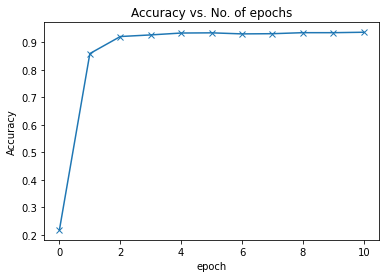

In [42]:
plot_scores(history)

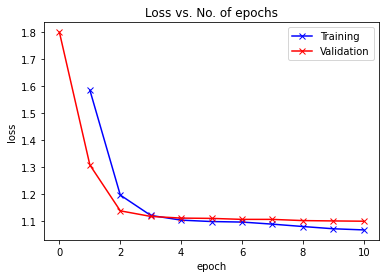

In [43]:
plot_losses(history)

Labels: buildings


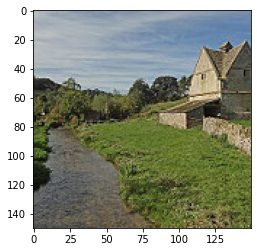

In [44]:
predict_image(test_ds[5][0],model)

Labels: forest


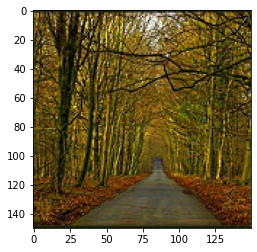

In [45]:
predict_image(test_ds[505][0],model)

Labels: glacier


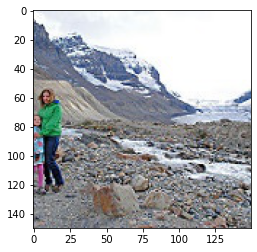

In [46]:
predict_image(test_ds[1005][0],model)

In [47]:
!pip install jovian --upgrade --quiet
import jovian
jovian.reset()
project_name='Project'
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/linkenny13/Project


<IPython.core.display.Javascript object>